In [1]:
# === Standard libraries ===
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile
import random
import unittest
import time


# === Numerical & Data ===
import numpy as np
import pandas as pd

# === PyTorch ===
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === Torchvision ===
from torchvision import transforms, models

# === Image Processing ===
from PIL import Image
import cv2

# === ML & Visualization ===
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


#### Defining The Functions

In [3]:

def crop_bbox_scaled(image, bbox, crop_factor):
    """
    Crop an RGB image around a bounding box, enlarging it by a crop factor.

    Parameters:
        image (np.ndarray): RGB image, shape (H, W, 3)
        bbox (tuple): (x_min, y_min, x_max, y_max)
        crop_factor (float): Scaling factor for the crop size

    Returns:
        np.ndarray: Cropped RGB image
    """
    x_min, y_min, x_max, y_max = bbox

    # Calculate bbox center
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2

    # Get max side of the bbox
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    max_dim = max(bbox_width, bbox_height)

    # Final crop size
    crop_size = int(np.ceil(max_dim * crop_factor))
    half_crop = crop_size // 2

    # Compute crop bounds
    y1 = max(center_y - half_crop, 0)
    y2 = min(center_y + half_crop, image.shape[0])
    x1 = max(center_x - half_crop, 0)
    x2 = min(center_x + half_crop, image.shape[1])

    croppedImage= image[y1:y2, x1:x2, :]
    print(croppedImage.shape)
    
    # Crop and return
    return image[y1:y2, x1:x2, :]


def plot_crops_with_predictions(original_image, crops_np, predictions, confidences, final_pred, final_conf, bbox=None):
    """
    Displays the original image with bbox and each crop with predicted label and confidence.

    Parameters:
        original_image (np.ndarray): RGB image
        crops_np (List[np.ndarray]): List of cropped RGB images
        predictions (List[str]): Predicted label per crop
        confidences (List[float]): Confidence score per crop
        final_pred (str): Aggregated prediction
        final_conf (float): Aggregated confidence
        bbox (tuple): (x_min, y_min, x_max, y_max) - optional
    """
    num_crops = len(crops_np)
    fig, axs = plt.subplots(1, num_crops + 1, figsize=(5 * (num_crops + 1), 5))

    # === Original image with optional bbox
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image\nFinal: {final_pred} ({final_conf:.2f})")
    axs[0].axis('off')

    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)

    # === Cropped patches with predictions
    for i, (crop, pred, conf) in enumerate(zip(crops_np, predictions, confidences)):
        if crop.size == 0:
            axs[i + 1].axis('off')
            axs[i + 1].set_title(f"Crop {i+1}\nEMPTY")
            continue
        axs[i + 1].imshow(crop)
        axs[i + 1].set_title(f"Crop {i+1}\n{pred} ({conf:.2f})")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


    
# def predict_crops_majority_vote(crops, model, bbox, device,
#                                  original_image=None,
#                                  crops_np=None,
#                                  plot=False):
#     """
#     Predicts fire presence using multiple crops of the same image.

#     Args:
#         crops (List[Tensor]): List of transformed image tensors [C, H, W]
#         model (nn.Module): Trained model
#         bbox (tuple): (x_min, y_min, x_max, y_max)
#         device (torch.device): cuda or cpu
#         original_image (np.ndarray): Full RGB image (for optional plotting)
#         crops_np (List[np.ndarray]): List of RGB crops (unprocessed)
#         plot (bool): Whether to show a plot of the prediction

#     Returns:
#         dict with prediction, confidence, and bbox
#     """

#     start_time = time.time()

#     model.eval()
#     batch = torch.stack(crops).to(device)
    
#     with torch.no_grad():
#         outputs = model(batch)
#         probs = F.softmax(outputs, dim=1)
#         preds = torch.argmax(probs, dim=1)

#     # Convert to labels and confidence values
#     label_names = {0: "No Fire", 1: "Fire"}
#     pred_labels = [label_names[p.item()] for p in preds]
#     confidence_scores = probs.max(dim=1).values.cpu().numpy().tolist()

#     # Voting logic
#     fire_votes = (preds == 1).sum().item()
#     vote_ratio = fire_votes / len(crops)
#     final_class = 1 if vote_ratio > 0.6 else 0
#     final_label = label_names[final_class]
#     avg_conf = probs[:, final_class].mean().item()

#     end_time = time.time()
#     elapsed = end_time - start_time
#     print(f"Inference time: {elapsed:.4f} seconds")

#     # Optional plot
#     if plot and original_image is not None and crops_np is not None:
#         plot_crops_with_predictions(
#             original_image,
#             crops_np,
#             pred_labels,
#             confidence_scores,
#             final_label,
#             avg_conf,
#             bbox=bbox
#         )

#     return {
#         "final_prediction": final_label,
#         "confidence": avg_conf,
#         "bbox": bbox
#     }

import time

def predict_crops_majority_vote(crops, model, bbox, device,
                                 original_image=None,
                                 crops_np=None,
                                 plot=False):
    label_names = {0: "No Fire", 1: "Fire"}
    
    times = {}

    t0 = time.time()
    model.eval()

    # Stage 1: Stack crops
    t1 = time.time()
    batch = torch.stack(crops)
    times['stack'] = time.time() - t1

    # Stage 2: Move to device
    t2 = time.time()
    batch = batch.to(device)
    times['to_device'] = time.time() - t2

    # Stage 3: Inference
    t3 = time.time()
    with torch.no_grad():
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
    times['inference'] = time.time() - t3

    # Stage 4: Post-processing
    t4 = time.time()
    pred_labels = [label_names[p.item()] for p in preds]
    confidence_scores = probs.max(dim=1).values.cpu().numpy().tolist()
    fire_votes = (preds == 1).sum().item()
    vote_ratio = fire_votes / len(crops)
    final_class = 1 if vote_ratio > 0.6 else 0
    final_label = label_names[final_class]
    avg_conf = probs[:, final_class].mean().item()
    times['postprocess'] = time.time() - t4

    total_time = time.time() - t0
    print(f"\n=== Inference Timing Breakdown ===")
    for k, v in times.items():
        print(f"{k:>12}: {v*1000:.2f} ms")
    print(f"{'Total':>12}: {total_time*1000:.2f} ms\n")

    # Optional plot
    if plot and original_image is not None and crops_np is not None:
        plot_crops_with_predictions(
            original_image,
            crops_np,
            pred_labels,
            confidence_scores,
            final_label,
            avg_conf,
            bbox=bbox
        )

    return {
        "final_prediction": final_label,
        "confidence": avg_conf,
        "bbox": bbox
    }


In [6]:


# # Input / Parameters:
# bbox = # Fire BBox in world coordinates
# image1 = 
# IR2RGB_ratio = 
# HFOV = # IR Fov in Phase1
# required_fov2 = 
# ratio_patch = 



# === 1. Load image (OpenCV loads as BGR, so convert to RGB)

import cv2
import numpy as np

# Load and convert to RGB
image_path = r"C:/Projects/Flame2/Datasets_FromDvir/Datasets/rgb_images/00216-fire-rgb-flame3.JPG"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Step 1: Resize image to 600x600
resized = cv2.resize(image_rgb, (600, 600), interpolation=cv2.INTER_LINEAR)

# Step 2: Create a black canvas (1080x1920)
image1 = np.zeros((1080, 1920, 3), dtype=np.uint8)

# Step 3: Compute top-left corner to paste the resized image in the center
y_offset = (1080 - 600) // 2
x_offset = (1920 - 600) // 2

# Step 4: Paste resized image into the center of the canvas
image1[y_offset:y_offset+600, x_offset:x_offset+600] = resized


# === 2. Check shape and dtype
print("Image shape:", image1.shape)
print("Dtype:", image1.dtype)        # should be uint8

# Using transformation function to convert World coordinates to RGB image coordinates
times = {}
tt0 = time.time()
# === 3. Define bbox
bbox_pixels = (960-140, 540-140, 960+140, 540+140)  # example bounding box

# === 4. Define crop factors and transformation
crop_factors = [1.5**0.5, 2**0.5, 2]
image_size = 224

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

cropped_images_np = []
test_tensors = []

for crop_factor in crop_factors:
    # Crop the image (NumPy RGB)
    cropped_np = crop_bbox_scaled(image1, bbox_pixels, crop_factor)
    cropped_images_np.append(cropped_np)  # Save for plotting

    # Convert to PIL and apply transforms
    pil_img = Image.fromarray(cropped_np)
    test_tensors.append(transform(pil_img))

total_time = time.time() - tt0
print(f"\n=== Inference Timing Breakdown === {total_time*1000}msec")

Image shape: (1080, 1920, 3)
Dtype: uint8
(342, 342, 3)
(396, 396, 3)
(560, 560, 3)

=== Inference Timing Breakdown === 0.01772022247314453



=== Inference Timing Breakdown ===
       stack: 0.00 ms
   to_device: 1.28 ms
   inference: 4725.37 ms
 postprocess: 1.00 ms
       Total: 4727.65 ms



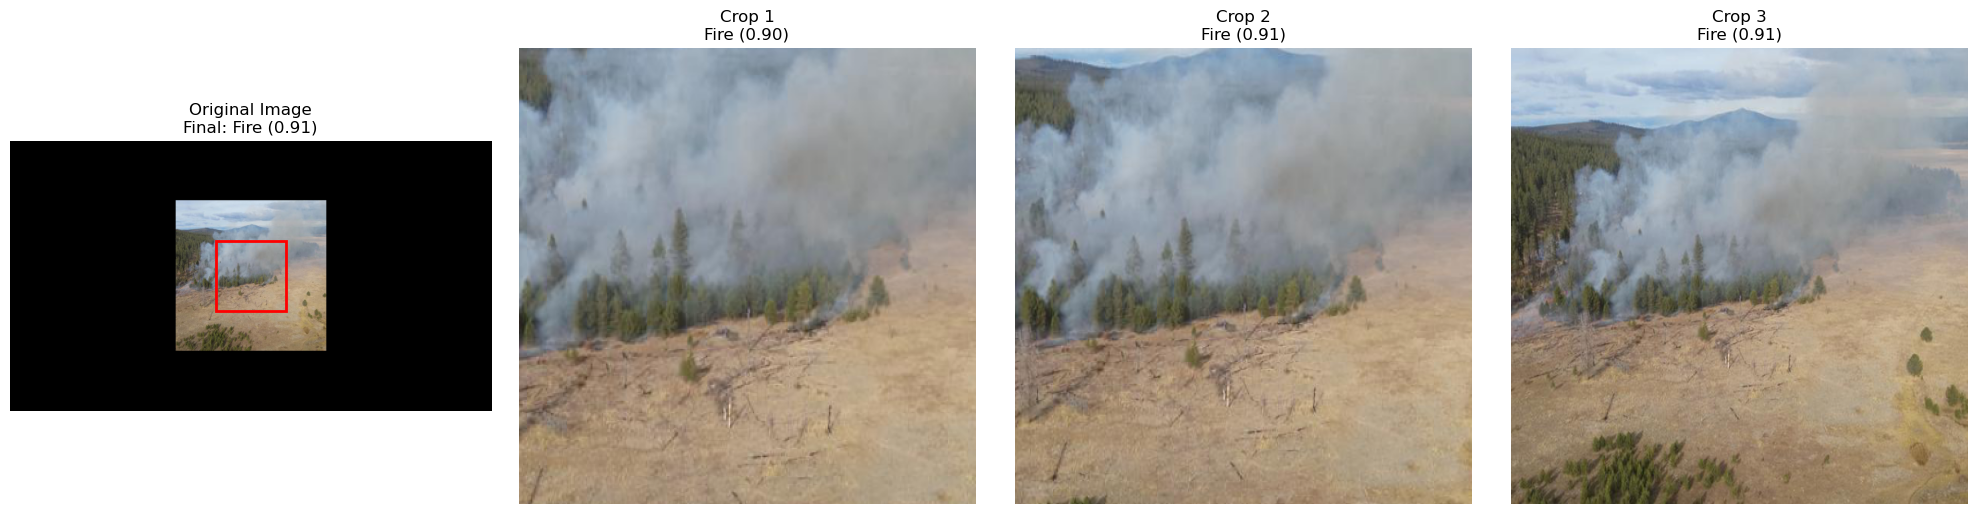

Final Prediction: Fire
Confidence: 0.91
BBox: (820, 400, 1100, 680)


In [5]:
tt1 = time.time()
# Load checkpoint
checkpoint = torch.load("resnet_fire_classifier.pt", map_location=device)

# Define model and load state
num_classes = 2
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
resnet.load_state_dict(checkpoint["model_state"])
resnet = resnet.to(device)
resnet.eval()

total_time = time.time() - tt1
print(f"\n=== Inference Timing Breakdown ===")

result = predict_crops_majority_vote(
    test_tensors,
    resnet,
    bbox_pixels,
    device,
    original_image=image1,
    crops_np=cropped_images_np,
    plot=True
)


print("Final Prediction:", result["final_prediction"])
print("Confidence:", f"{result['confidence']:.2f}")
print("BBox:", result["bbox"])